# Train a baseline model for Subchallenge 1

We'll train a RidgeRegression model on RNASeq data for each inhibitor to predict AUC. Specifically:

- Select the 1000 highest variance genes
- For each inhibitor, train with leave-one-out cross validation
- Try a bunch of alpha values

### First, download training data.

This only needs to be run once, to populate the `training/` directory.

In [4]:
#%pip install synapseclient

import getpass
import pandas
import synapseclient
import synapseutils

syn = synapseclient.Synapse()
syn.login(input(prompt="Enter Synapse Username"), getpass.getpass("Enter Synapse Password"))
downloaded_files = synapseutils.syncFromSynapse(syn, 'syn21212904', path='training') 

KeyboardInterrupt: 

### Now, load the data, and train a model!

In [2]:
import pandas
# data
rnaseq = pandas.read_csv('training/rnaseq.csv')
# gt
aucs = pandas.read_csv('training/aucs.csv')

In [61]:
from util import TransposeRnaSeqTable
# Select the 1000 highest variance genes
specimens = TransposeRnaSeqTable(rnaseq)
selected_genes = specimens.var().nlargest(2400).index.tolist()

In [62]:
print("%.1f%% of (inhibitor, specimen) pairs have AUCs." % (
    100 * aucs.shape[0] / float(len(aucs.inhibitor.unique()) * len(aucs.lab_id.unique()))))
# 需要做缺失值处理？

77.9% of (inhibitor, specimen) pairs have AUCs.


In [63]:
from matplotlib import pyplot
import numpy
import seaborn
from sklearn.linear_model import RidgeCV

# Normalize each specimen.
X = specimens
X = X.div(numpy.linalg.norm(X, axis=1), axis=0)
X = X[selected_genes]

# Compute z-score.
gene_mean = X.mean(axis=0)
gene_std = X.std(axis=0)
X = (X - gene_mean) / gene_std

# For each inhibitor, train a regressor.
alphas = numpy.logspace(-1, 5, num=40) # 随机alpha
regressors = {}
for inhibitor in aucs.inhibitor.unique():
    auc_subset = aucs[aucs.inhibitor == inhibitor]
    regr = RidgeCV(alphas=alphas, store_cv_values=True) #
    regr = regr.fit(X.loc[auc_subset.lab_id], auc_subset.auc)  
    regressors[inhibitor] = regr

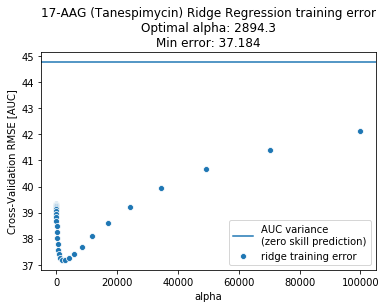

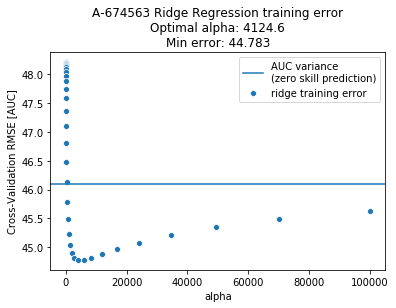

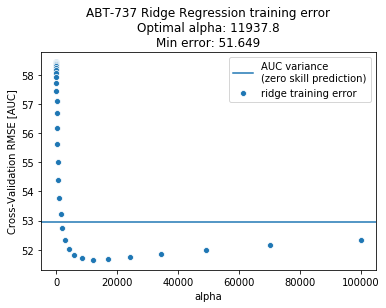

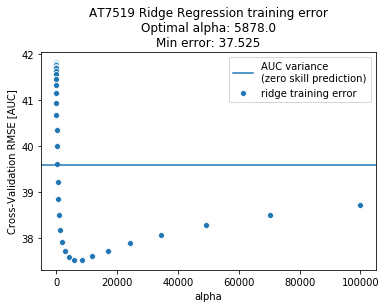

In [64]:
# Plot the highest error and lowest error.
def plotRegressor(inhibitor, regr):
    pyplot.figure()
    errors = numpy.sqrt(regr.cv_values_.mean(axis=0))
    seaborn.scatterplot(x=alphas, y=errors, label='ridge training error')
    pyplot.axhline(
        y=aucs[aucs.inhibitor == inhibitor].auc.std(), # 矩阵标准差 衡量价值？都从auc而来
        label='AUC variance\n(zero skill prediction)')

    # Annotate.
    pyplot.xlabel('alpha')
    pyplot.ylabel('Cross-Validation RMSE [AUC]')
    pyplot.title('%s Ridge Regression training error\nOptimal alpha: %0.1f\nMin error: %.3f' % (
        inhibitor, regr.alpha_, min(errors)))
    pyplot.legend()

for inhibitor in aucs.inhibitor.unique()[0:4]:
    plotRegressor(inhibitor, regressors[inhibitor])

### Store the model information in `model/`

In python this process is sometimes referred to as "pickling," thus the variable names "pkl_1" and "pkl_2".

In [65]:
pkl_1_dict = {
    'gene': selected_genes,
    'gene_mean': gene_mean,
    'gene_std': gene_std,
}
for inhibitor, regr in regressors.items():
    pkl_1_dict[inhibitor] = regr.coef_
pkl_1_out = pandas.DataFrame(pkl_1_dict)

pkl_2_out = pandas.DataFrame({
    'inhibitor': [inhibitor for inhibitor in regressors.keys()],
    'intercept': [regr.intercept_ for regr in regressors.values()],
})
pkl_1_out.to_csv('model/pkl_1.csv', index=False)
pkl_2_out.to_csv('model/pkl_2.csv', index=False)

### Run the model

We run the model with

```bash
SYNAPSE_PROJECT_ID=<your project ID> #syn21555820
docker build -t docker.synapse.org/$SYNAPSE_PROJECT_ID/sc1_model .
docker run \
    -v "$PWD/training/:/input/" \
    -v "$PWD/output:/output/" \
    docker.synapse.org/$SYNAPSE_PROJECT_ID/sc1_model

# Maybe push to Synapse.
docker login docker.synapse.org
docker push docker.synapse.org/$SYNAPSE_PROJECT_ID/sc1_model
```
**Note: you must pass the Synapse [certified user test](https://docs.synapse.org/articles/accounts_certified_users_and_profile_validation.html#certified-users) before you can push to the Synapse docker hub.**
### Look at predictions vs goldstandard for training data

Assumes predictions are in `output/predictions.csv`. Note that the performance on training dataset is going to be better than on the leaderboard data. Therefore, this is a good test of formatting / sanity check, but not of predictive performance.

In [26]:
# Join groundtruth onto predictions, because predictions is a
# superset of groundtruth.
indices = ['lab_id', 'inhibitor']
groundtruth = pandas.read_csv('training/aucs.csv').set_index(indices)
predictions = pandas.read_csv('output/predictions.csv').set_index(indices)
predictions_and_groundtruth = groundtruth.join(
    predictions, lsuffix='_groundtruth', rsuffix='_prediction')

Text(0.5,1,'SC1 baseline predictor')

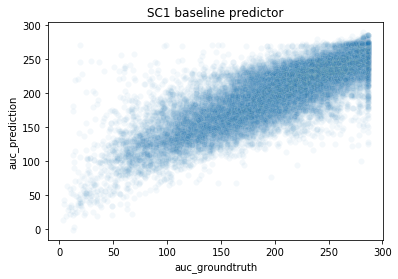

In [27]:
seaborn.scatterplot(
    x='auc_groundtruth',
    y='auc_prediction',
    data=predictions_and_groundtruth,
    alpha=0.05)
pyplot.title('SC1 baseline predictor')